# Chapter 11 训练深度神经网络

## Setup

In [2]:
# This project requires Python 3.7 or above:

import sys

assert sys.version_info >= (3, 7)

In [3]:
# TensorFlow ≥ 2.8:

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
# define the default font sizes to make the figures prettier:

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
# create the images/deep folder (if it doesn't already exist)
# define the save_fig() function which is used to save the figures:

from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

在第10章中，你构建、训练和微调了你的第一个人工神经网络。但它们是浅网，只有几个隐藏层。如果你需要解决一个复杂的问题，比如在高分辨率图像中检测数百种类型的物体怎么办？

你可能需要训练一个更深的神经网络，可能有10层或更多，每层包含数百个神经元，由成千上万的连接连接。以下是你可能会遇到的一些问题：

1. 当在训练过程中反向通过DNN时，你可能会遇到梯度越来越小或越来越大的问题。这两种问题都使较低的层次很难进行训练。
2. 可能没有足够的训练数据来处理如此大的网络，或者获取标签代价可能太高。
3. 训练可能会非常缓慢。
4. 一个有数百万个参数的模型会严重面临过拟合训练集的风险，特别是当没有足够的训练实例或噪声太大时。

在本章中，我们将详细讨论这些问题，并介绍解决这些问题的技术。我们将从探索消失和爆炸的梯度问题及其一些最流行的解决方案开始。接下来，我们将研究迁移学习和无监督的预训练，它可以帮助你处理复杂的任务，即使你有很少的标记数据。然后，我们将讨论各种可以极大地加快训练大型模型的各种优化器。最后，我们将介绍一些流行的大型神经网络的正则化技术。

## 1. 梯度消失或梯度爆炸问题（The Vanishing/Exploding Gradients Problems）

**消失梯度问题（vanishing gradients problem）**：随着算法向下发展到较低的层，梯度通常会越来越小，最终梯度下降更新使较低层的连接权值几乎保持不变，训练永远不会收敛到一个好的解决方案。

**梯度爆炸问题（exploding gradients problem）**：在某些情况下，可能会发生相反的情况：梯度可能会越来越大，直到各层得到异常大的权重更新，算法就会发散，在循环神经网络中最容易实现。

更一般地说，深度神经网络存在不稳定的梯度；不同的层可能以不同的速度学习。

这种不幸的行为在很久以前就被经验观察到了，这也是深度神经网络在21世纪初被抛弃的原因之一。目前还不清楚是什么导致了在训练DNN时的梯度如此不稳定，但泽维尔·格洛罗特和约舒亚·本吉奥在2010年的一篇论文中发现了一些启示。作者发现了一些怀疑点，包括流行的 sigmoid 激活函数和当时最流行的权重初始化技术（即均值为0、标准差为1的正态分布）的组合。简而言之，他们表明，使用这个激活函数和这个初始化方案，每一层输出的方差都远远大于其输入的方差。在网络中，方差在每一层之后不断增加，直到激活函数在顶层饱和。由于 sigmoid 函数的均值为0.5，而不是0（双曲正切函数的均值为0，在深度网络中比 sigmoid 函数稍好），这种饱和变得更糟。

查看 sigmoid 激活函数，您可以看到当输入变大（负或正）时，函数在0或1时饱和，导数极接近于0（即，曲线在两个极端都是平坦的）。因此，当反向传播开始时，它实际上没有梯度通过网络传播回，并且随着反向传播通过顶层向下进行，存在的小梯度不断被稀释，所以较低的层真的没有任何东西了。

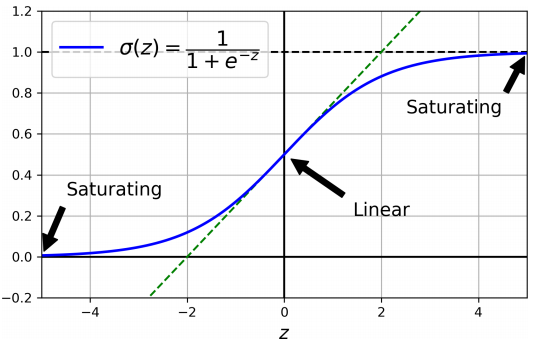

## 2. Glorot 和他的初始化（Glorot and He Initialization）

在他们的论文中，Glorot提出了一种**显著缓解不稳定梯度**问题的方法。他们指出，我们需要信号在两个方向上正确地流动：在进行预测时是正向方向，在反向传播梯度时是反向方向。我们不希望信号消失，也不希望它爆炸和饱和。为了使信号正确流动，作者认为，我们需要每一层的输出的方差等于方差的输入，并且我们需要梯度在反向流过一层前后都有相等的方差。

实际上是不可能保证两者都实现的，除非层有相同数量的输入和输出（这些数量称为扇入 $fan_{in}$ 和扇出 $fan_{out}$），但Glorot和Bengio提出了一个好的折衷，已证明在实践中工作：每一层的连接权重必须按如下公式随机初始化

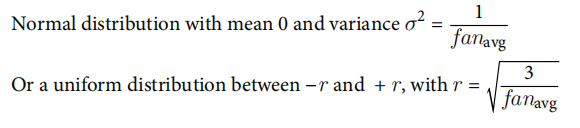

其中 $fan_{avg}=\frac{fan_{in}+fan_{out}}{2}$ 。这种初始化策略称为 **Xavier初始化** 或 **Glorot初始化** 。

如果用 $fan_{in}$ 替换 $fan_{avg}$ ，你会得到Yann LeCun在20世纪90年代提出的初始化策略，也就是**勒村初始化**。勒村初始化相当于当 $fan_{in}=fan_{out}$ 时的Glorot初始化。研究人员花了十多年的时间才意识到这个技巧有多么重要。使用Glorot初始化可以大大加快训练速度，这是导致深度学习成功的实践之一。

一些论文为不同的激活函数提供了类似的策略。这些策略的不同之处仅在于方差的规模和它们是使用 $fan_{avg}$ 还是 $fan_{in}$ ，如下所示

**每种类型的激活函数的初始化参数**：

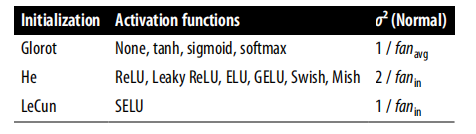


针对ReLU激活函数及其变体提出的初始化策略称为 **He初始化** 或 **Kaiming初始化**。对于SELU，使用YannLeCun的初始化方法，最好是正态分布。我们将很快介绍所有这些激活功能。

**Keras默认使用了具有均匀分布的Glorot初始化**。

创建层时，可以切换到 He初始化，只需要设置 **kernel_initializer="he_uniform"** 或 **kernel_initializer="he_normal"**

In [1]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

或者，可以使用 **VarianceScaling初始化器** 获得上表中列出的任何初始化。例如，如果想要均匀分布的He初始化，并基于 $fan_{avg}$，您可以使用以下代码：

In [6]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., 
                                                    mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## 3. 更好的激活函数（Better Activation Functions）

Glorot和Bengio在2010年的论文中提出的一个见解是，不稳定梯度的问题部分是由于激活函数的选择不佳。在那之前，大多数人都认为，如果大自然选择在生物神经元中使用大致的 Sigmoid 激活函数，那么它们一定是一个很好的选择。但事实证明，其他激活函数在深度神经网络中表现得更好——特别是ReLU激活函数，主要是因为它对正值不饱和，也因为它的计算速度非常快。

不幸的是，ReLU的激活功能并不完美。它有一个被称为 **dying ReLUs** 的问题：在训练过程中，一些神经元有效地“死亡”，这意味着它们停止输出除0以外的任何东西。在某些情况下，你可能会发现你的神经网络中有一半的神经元已经死亡，特别是如果你使用了很大的学习率。当一个神经元的权值被调整为ReLU函数的输入（即神经元输入的加权和加上偏差项）对于训练集的所有实例都为负时，它就会死亡。当这种情况发生时，它只是继续输出零，并且梯度下降不再影响它，因为当其输入为负时，ReLU函数的梯度为零。

要解决这个问题，您可能希望使用ReLU函数的变体，例如 **leaky ReLU** 。

### 3.1 Leaky ReLU

leaky ReLU 激活函数被定义为 $LeakyReLU_{\alpha}(z)=max(\alpha z,z)$

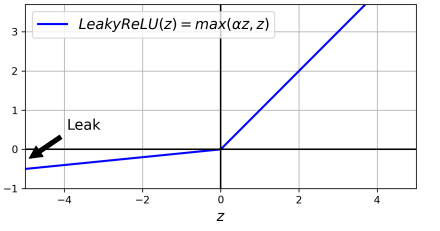

超参数 $\alpha$ 定义了函数“泄漏”的程度：它是 $z<0$ 的函数的斜率。$z<0$ 的斜率确保leaky ReLUs不会死亡；他们可能会进入长时间昏迷，但他们最终有机会醒来。Bing Xu等人在2015年的一篇论文中比较了ReLU激活函数的几种变体，其结论之一是 leaky ReLU 总是比严格 ReLU 的表现要好。事实上，设置 $\alpha=0.2$（一个巨大的泄漏）似乎比 $\alpha=0.01$（一个小的泄漏）会导致更好的性能。论文还评估了**randomized leaky ReLU (RReLU)** ，其中 $\alpha$ 在训练过程中在给定范围内随机选取，并在测试过程中固定为平均值。RReLU似乎作为一个规则化器也表现得相当好，减少了过拟合训练集的风险。最后，文章评估了参数泄漏**parametric leaky ReLU (PReLU)**，其中 $\alpha$ 被授权在训练过程中被学习：它不是一个超参数，而是成为一个可以像任何其他参数一样通过反向传播进行修改的参数。据报道，PReLU在大型图像数据集上的表现强烈优于ReLU，但在较小的数据集上，它存在过拟合训练集的风险。

Keras在tf.keras.layers软件包中包含了**LeakyReLU**和**PReLU**这两个类。就像其他ReLU变体一样，您应该使用 He 初始化。例如：

In [7]:
# defaults to alpha=0.3
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2) 

dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

如果您愿意，也可以使用LeakyReLU作为模型中的一个单独的层；这对训练和预测没有影响：

In [9]:
model = tf.keras.models.Sequential([
 # more layers
 tf.keras.layers.Dense(50, kernel_initializer="he_normal"), # no activation
 tf.keras.layers.LeakyReLU(alpha=0.2), # activation as a separate layer
 # more layers
])

对于PReLU，用PReLU替换LeakyReLU。目前在Keras中还没有正式实现RReLU，但是可以相当容易地实现自己的实现（要学习如何做到这一点，请参见第12章末尾的练习）。

ReLU、leaky ReLU 和 PReLU 都存在不是光滑函数的事实：它们的导数突然变化（在 $z=0$ 处）。这种不连续会使梯度下降在最优值周围反弹，并减缓收敛速度。所以现在我们来看看ReLU激活函数的一些平滑变体，从ELU和SELU开始。

### 3.2 ELU and SELU

2015年，Djork-Arne Clevert等人的一篇论文提出了一种新的激活函数，称为**指数线性单元（exponential linear unit，ELU）**，该函数在作者的实验中优于所有的ReLU变体：训练时间减少，神经网络在测试集上表现更好。

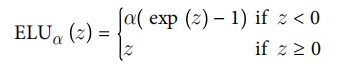

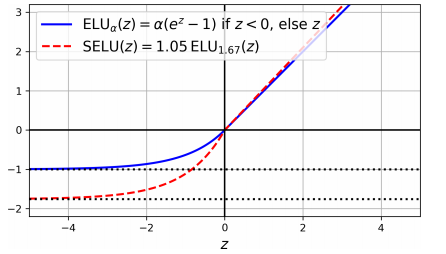

**ELU激活函数看起来很像ReLU函数，但有一些主要的区别**：

1. 当 $z<0$ 时，它呈现负值，这使得单元的平均输出更接近于0，有助于缓解梯度消失的问题。超参数 $\alpha$ 定义了与 $z$ 为大负数时ELU函数接近的值的相反数。它通常被设置为1，但是你可以像任何其他超参数一样调整它。
2. 它对 $z<0$ 具有非零梯度，避免了死亡神经元的问题。
3. 如果 $\alpha$ 等于1，那么函数在任何地方都是平滑的，包括在 $z=0$ 左右，这有助于加速梯度下降，因为它不会在 $z=0$ 的左右反弹。

在Keras中使用ELU就只需设置 **activation="elu"** ，并且像使用其他ReLU变体一样，您应该使用**He初始化**。ELU激活函数的主要缺点是它的计算速度比ReLU函数及其变体要慢（由于使用了指数函数）。它在训练过程中较快的收敛速度可以弥补这种缓慢的计算，但在测试时，ELU网络仍然会比ReLU网络慢一些。

不久之后，Gunter Klambauer等人在2017年的一篇论文中介绍了 **scaled ELU（SELU）** 激活函数：正如顾名思义，它是ELU激活函数的缩放变体（约1.05倍ELU，使用α≈1.67）。**作者表明，如果你建立一个完全由一堆密集的层（即MLP）组成的神经网络，如果所有隐藏层使用SELU激活函数，那么网络将自我规范化：每一层的输出将倾向于保持平均0和标准偏差1在训练期间，解决了消失/爆炸梯度的问题**。因此，SELU的激活功能可能优于其他激活功能，特别是深层激活功能。要与Keras一起使用，只需设置 **activation="selu"**。

**然而，有一些条件可以发生自我规范化（见论文的数学证明）**：

1. 输入特征必须标准化：平均值0和标准差1。
2. 每个隐层的权值必须使用**勒村初始化**进行初始化。在Keras中，这意味着设置 **kernel_initializer="lecun_normal"**。
3. 只有用普通的MLPs才能保证自规范化的性质。如果您尝试在其他架构中使用SELU，如循环网络或具有跳过连接的网络（即跳过层的连接，如宽网和深网），它的性能可能不会优于ELU。
4. 不能使用正则化技术，如 $ℓ1$ 或 $ℓ2$ 正则化、最大范数、批处理范数或常规退出（这些将在本章后面讨论）。

这些都是重大的限制，所以SELU并没有获得很大的吸引力。此外，另外三个激活功能似乎在大多数任务上都表现得相当优于它： GELU、Swish和Mish。

### 3.3 GELU, Swish, and Mish

**GELU**是由Dan Hendrycks和Kevin Gimpel在2016年的一篇论文中介绍的。你可以把它看作是ReLU激活函数的平滑变体。它的定义如下，

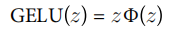

其中 $Φ$ 是标准高斯累积分布函数（CDF）：$Φ(z)$ 对应于从均值0和方差1的正态分布中随机采样的值小于z的概率。

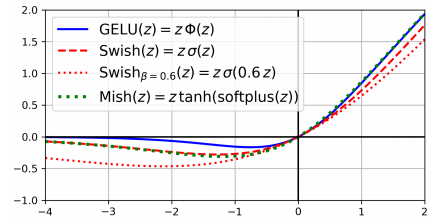

如图中所看到的，GELU类似于ReLU：当其输入 $z$ 非常负时它接近0，当z非常正时它接近 $z$ 。然而，尽管所有的激活函数我们讨论迄今为止都是凸和单调，GELU激活函数都不是：从左到右，直接开始，然后摆动，达到一个低点附近-0.17（$z\approx-0.75$），最后反弹，最终直接向右上角。这种相当复杂的形状以及它在每一个点上都有曲率的事实可以解释为什么它如此好，特别是对于复杂的任务：梯度下降可能会发现它更容易适应复杂的模式。在实践中，它的性能往往优于迄今为止讨论的其他激活函数。然而，它的计算强度更大一些，而且它所提供的性能提升并不总是足以证明额外的成本是合理的。也就是说，有可能证明它近似等于 $z\sigma$（$1.702z$），其中 $\sigma$ 是sigmoid 函数：使用这个近似也工作得很好，而且它具有计算速度更快的优点。

GELU的论文还引入了 **sigmoid 线性单元（SiLU）** 激活函数，它等于 $z\sigma(z)$ ，但在作者的检验中优于GELU。其中，由Prajit Ramachandran等人在2017年发表的一篇论文中，通过自动搜索良好的激活函数，重新发现了SiLU函数。作者把它命名为**Swish**，这个名字流行起来。在他们的论文中，Swish的表现优于其他所有功能，包括GELU。Ramachandran等人后来通过添加一个额外的超参数 $β$ 来扩展 sigmoid 函数的输入来推广Swish。广义的Swish函数是 $Swish_{\beta}(z)=z\sigma(\beta z)$ ，因此GELU近似等于使用 $β = 1.702$ 的广义Swish函数。您可以像任何其他超参数一样调优$β$。另外，它也可以使$β$可训练，并让梯度下降优化它：很像PReLU，这可以使你的模型更强大，但它也存在过拟合数据的风险。

另一个非常相似的激活函数是Mish，这是Diganta Misra在2019年的一篇论文中介绍的。它被定义为 $mish(z)=ztanh(softplus(z))$，其中 $softplus(z)=log(1+exp(z))$ 。就像GELU和Swish一样，它是ReLU的光滑、非凸和非单调变体，作者再次进行了许多实验，发现Mish通常优于其他激活函数——甚至是Swish和GELU。如上图显示了GELU、Swish（都使用默认的 $β=1$ 和 $β=0.6$ ），最后是Mish。正如你所看到的，当 $z$ 为负时，Mish与Swish几乎完全重叠，而当 $z$ 为正时，Mish与GELU几乎完全重叠。

**那么应该使用哪个激活功能来处理深度神经网络的隐藏层呢?**

对于简单的任务，ReLU仍然是一个很好的默认值：它通常和更复杂的激活函数一样好，而且它的计算速度非常快，而且许多库和硬件加速器提供了特定于ReLU的优化。然而，对于更复杂的任务，Swish可能是一个更好的默认设置，您甚至可以为最复杂的任务尝试使用可学习的 $\beta$ 参数进行参数化的Swish。Mish可能会给你稍微更好的结果，但它需要更多的计算。如果您非常关心运行时延迟，那么您可能更喜欢leaky ReLU，或者为更复杂的任务选择parametrized leaky ReLU。对于深度MLPs，请尝试一下SELU，但请确保尊重前面列出的约束条件。如果您有空闲时间和计算能力，您还可以使用交叉验证来评估其他激活函数。

Keras支持GELU和Swish，只需使用 **activation="gelu"** 或 **activation="swish"** 。但是，它还不支持Mish或扩展的Swish激活函数（但请参见第12章，以了解如何实现您自己的激活函数和层）。

这一切都是为了激活函数！现在，让我们来看看一种完全不同的解决不稳定梯度问题的方法：批处理标准化。

## 4. 批处理标准化（Batch Normalization）

尽管在训练开始时使用He初始化和ReLU（或它的任何变体）可以显著减少训练开始时消失/爆炸的梯度问题的危险，但这并不能保证它们在训练期间不会回来。

在2015年的一篇论文中，Sergey Ioffe和Christian Szegedy提出了一种称为 **批处理归一化（Batch Normalization，BN）** 的技术来解决这些问题。该技术包括在每个隐藏层的激活函数之前或之后在模型中添加一个操作。这个操作简单地设置零中心并对每个输入进行标准化，然后使用两个新的参数向量对结果进行缩放和移位：一个用于缩放，另一个用于移位。换句话说，该操作允许模型学习每个层输入的最优尺度和平均值。在许多情况下，如果您添加一个BN层作为神经网络的第一层，则不需要标准化训练集。也就是说，不需要StandardScaler或Normalization；BN层将会做这些（只是近似地，因为它一次只看一个批处理，它还可以重新缩放和移动每个输入特性）。

为了使输入为零中心和归一化，算法需要估计每个输入的均值和标准差。它通过评估输入对当前小批的平均值和标准偏差来实现这一点（因此称为“批标准化”）。

**整个操作总结如下**：
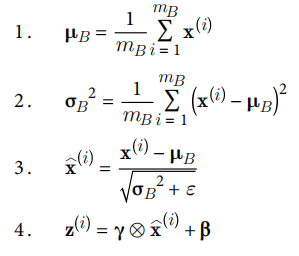

1. $\pmb{\mu}_B$ 是输入均值的向量，计算整个 mini-batch B（它包含每个输入的一个平均值）。
2. $m_B$ 是 mini-batch 处理中的实例数量。
3. $\pmb{\sigma}_B$ 是输入标准差的向量，也在整个 mini-batch 中进行评估（每个输入包含一个标准差）。
4. $\hat{\pmb{x}}^{(i)}$是实例 $i$ 零中心和标准化输入的向量。
5. $\epsilon$ 是一个很小的数字，它避免了除以零，并确保梯度不会变得太大（通常是$10^{-5}$）。这被称为平滑项。
6. $\pmb{\gamma}$ 是该层的输出规模参数向量（它包含每个输入一个规模参数）。
7. $\otimes$ 表示元素级乘法（每个输入乘以其对应的输出规模参数）。
8. $\pmb{\beta}$ 是图层的输出偏移量的参数向量（每个输入包含一个偏移量参数）。每个输入都被其相应的移位参数所偏移。
9. $\pmb{z}^{(i)}$ 是BN运算的输出。它是输入的一个重新调整和移动的版本。

因此，在训练过程中，BN标准化其输入，然后重新缩放和偏移它们。那么在测试时该怎么样？事情也没那么简单。实际上，我们可能需要对单个实例进行预测，而不是对批量实例：在这种情况下，我们将没有办法计算每个输入的平均值和标准差。此外，即使我们确实有一批实例，它也可能太小，或者实例可能不是独立同分布的，因此对批实例计算统计数据是不可靠的。

一种解决方案可能是等到训练结束后，然后通过神经网络运行整个训练集，并计算BN层的每个输入的平均值和标准差。在进行预测时，这些“最终”输入的均值和标准差可以用来代替批输入的均值和标准差。然而，大多数批处理归一化的实现在训练期间通过使用图层的输入平均值和标准偏差的移动平均值来估计这些最终的统计数据。这是使用批规范化层时Keras自动执行的操作。综上所述，在每个批归一化层中学习四个平行向量：$\pmb{\gamma}$（输出尺度向量）和 $\pmb{\beta}$（输出偏移向量），使用指数移动平均估计的 $\pmb{\mu}$（最终输入平均向量）和 $\pmb{\sigma}$（最终输入标准差向量）。请注意，$\pmb{\mu}$ 和 $\pmb{\sigma}$ 是在训练过程中估计的，但它们只在训练后使用（用于替换公式中的批输入平均值和标准差）。

Ioffe和Szegedy证明，批归一化显著改善了他们实验的所有深度神经网络，导致了ImageNet分类任务的巨大改进（ImageNet是一个分为许多类的大型图像数据库，通常用于评估计算机视觉系统）。消失梯度问题被大大减少，减少到他们可以使用饱和激活函数，如tanh，甚至 sigmoid 激活函数。网络对权重初始化的影响也不那么敏感。作者能够使用更大的学习率，显著地加快了学习过程。具体来说，他们注意到：应用于最先进的图像分类模型，批归一化以减少14倍的训练步骤达到了相同的精度，并显著超过了原始模型。使用批归一化网络的集成，我们改进了ImageNet分类的最佳发布结果：达到4.9%的前5名验证误差（和4.8%的测试误差），超过了人类评分者的准确性。

最后，就像一个不断给予的礼物一样，批处理规范化就像一个正则化器，减少了对其他正则化技术的需要（如退出，本章后面将描述）。但是，批处理规范化确实增加了模型的一些复杂性（尽管它可以消除对输入数据进行规范化的需要，如前所述）。此外，还有一个运行时惩罚：由于每一层都需要额外的计算，神经网络会做出较慢的预测。幸运的是，通常可以在训练后将BN层与前一层融合，从而避免运行时的惩罚。这是通过更新前一层的权重和偏差来实现的，以便它直接产生适当的规模和偏移量的输出。例如，如果前一层计算 $\pmb{XW} + \pmb{b}$ ，那么BN层将计算 $\pmb{γ}⊗（\pmb{XW}+\pmb{b}-\pmb{μ}）/\pmb{σ}+\pmb{β}$（忽略分母中的平滑项 $ε$）。如果我们定义 $\pmb{W'}=\pmb{γ}⊗\pmb{W}/\pmb{σ}$ 和b’=γ⊗（b-μ）/σ+β，则方程简化为 $pmb{XW}'+\pmb{b}'$ 。因此，如果我们用更新的权重和偏差（ $\pmb{W}'$ 和 $\pmb{b}'$ ）替换前一层的权重和偏差（ $\pmb{W}$ 和 $\pmb{b}$ ），我们就可以摆脱BN层（TFLite的转换器会自动完成这个任务；见第19章）。

### 4.1 使用Keras实现批处理规范化（Implementing batch normalization with Keras）

与Keras的大多数事情一样，实现批处理规范化是简单和直观的。只需在每个隐藏层的激活函数之前或之后添加一个批规范化层。您也可以在模型中添加一个BN层作为第一层，但是普通的规范化层通常在这个位置执行得同样好（它唯一的缺点是必须首先调用它的 **adapt()** 方法）。

例如，该模型在每个隐藏层之后应用BN，并作为模型的第一层（在将输入图像变平之后）：

In [10]:
model = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=[28, 28]),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(300, activation="relu",
                       kernel_initializer="he_normal"),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(100, activation="relu",
                       kernel_initializer="he_normal"),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dense(10, activation="softmax")
])

在这个只有两个隐藏层的小例子中，批处理规范化不太可能产生很大的影响，但对于更深层次的网络，它可以产生巨大的影响。

In [11]:
# Let’s display the model summary:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

如您所看到的，每个BN层为每个输入添加四个参数：$\pmb{γ}$、$\pmb{β}$、$\pmb{μ}$ 和 $\pmbσ$（例如，第一个BN层添加了3136个参数，即4×784）。最后两个参数，$\pmb{μ}$ 和 $\pmb{σ}$，它们不受反向传播的影响，所以Keras称它们为“不可训练”（如果你计算BN参数的总数，3136+1200+400，再除以2，得到2368，这是这个模型中不可训练参数的总数）。

In [12]:
# Let’s look at the parameters of the first BN layer
# Two are trainable (by backpropagation), and two are not:

[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

BN论文的作者主张在激活函数之前添加BN层，而不是在激活功能之后（就像我们刚才做的那样）。关于这个有一些争论，因为哪个似乎更可取取决于任务——你也可以尝试这个，看看哪个选项在你的数据集上最有效。要在激活函数之前添加BN层，必须从隐藏层中删除激活函数，并将其作为BN层之后单独的层添加。此外，由于批处理归一化层每个输入包含一个偏移参数，您可以在创建时通过传递**use_bias=False**来从前一层中删除偏置项。最后，您通常可以删除第一个BN层，以避免将第一个隐藏层夹在两个BN层之间。

更新后的代码如下所示：

In [13]:
model = tf.keras.Sequential([
 tf.keras.layers.Flatten(input_shape=[28, 28]),
 tf.keras.layers.Dense(300, kernel_initializer="he_normal",
                       use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Activation("relu"),
 tf.keras.layers.Dense(100, kernel_initializer="he_normal",
                       use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Activation("relu"),
 tf.keras.layers.Dense(10, activation="softmax")
])

BatchNormalization类有相当多的一些可以调整的超参数。默认值通常会很正常，但您可能偶尔需要调整 **momentum** 。该超参数在批归一化层更新指数移动平均值时使用；给定一个新的值 $\pmb{v}$（即，在当前批上计算的输入均值或标准差的新向量），该层使用以下方程更新运行平均值 $\hat{\pmb{v}}$ ：

$$\hat{\pmb{v}}\leftarrow \hat{\pmb{v}}\times momentum+\pmb{v}\times(1-momentum) $$

良好的momentum值通常接近于1；例如，分别为0.9、0.99或0.999。对于更大的数据集和更小的小批量，您需要更多的9。

另一个重要的超参数是 **axis** ：它决定了哪个轴应该被归一化。它的默认值为-1，这意味着在默认情况下，它将规范化最后一个轴（使用跨其他轴计算的平均值和标准差）。当输入批处理为2D（即批处理形状为 **\[batch size, features\]** ）时，这意味着每个输入特征将基于批处理中所有实例计算的平均值和标准差进行标准化。

例如，前一个代码示例中的第一个BN层将独立地对784个输入特征中的每个特征进行规范化（并重新缩放和移位）。如果我们将第一个BN层移到Flatten层之前，那么输入批将为3D，形状 **\[batch size, height, width\]** ；因此，BN层将计算28个平均值和28个标准差（每列像素1个，计算批中的所有实例和列中的所有行），并且它将使用相同的平均值和标准差对给定列中的所有像素进行规范化。也将只有28个尺度参数和28个移位参数。如果你仍然想独立地处理每个784个像素，那么你应该设置 **axis=\[1, 2\]** 。

批处理归一化已经成为深度神经网络工作中最常用的层之一，特别是在（第14章）中讨论的深度卷积神经网络，因此在架构图中经常被省略：假设在每一层之后都添加了BN。现在让我们来看看在训练过程中稳定梯度的最后一种技术：梯度剪切。

## 5. 梯度裁剪（Gradient Clipping）

另一种缓解爆炸梯度问题的技术是在反向传播过程中裁剪梯度，使它们永远不会超过某个阈值。这叫做梯度剪切。这种技术通常用于递归神经网络，在那里使用批处理归一化是很棘手的（正如您将在第15章中看到的）。

在Keras中，实现梯度裁剪只是在创建优化器时设置 clipvalue 或 clipnorm 参数，如下所示：

In [15]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile([...], optimizer=optimizer)

这个优化器将把梯度向量的每个组件裁剪到-1.0和1.0之间的值。这意味着所有损失的偏导数（关于每个可训练的参数）将被夹在-1.0和1.0之间。该阈值是一个您可以调优的超参数。

请注意，它可能会改变梯度向量的方向。例如，如果原始的梯度向量为\[0.9,100.0\]，它主要指向第二个轴的方向；但是一旦你按值剪辑它，你将得到\[0.9,1.0\]，它大致指向两个轴之间的对角线。在实践中，这种方法效果很好。如果要确保渐变剪切不会改变渐变矢量的方向，应该通过设置**clipnorm**而不是**clipvalue**来按标准进行剪辑。如果它的 $ℓ2$ 范数大于您所选择的阈值，这将裁剪整个梯度。例如，如果您设置clipnorm=1.0，那么向量\[0.9,100.0\]将被剪切到\[0.00899964,0.9999595\]，保留其方向，但几乎消除了第一个分量。如果您在训练期间观察到梯度爆炸（您可以使用张量板跟踪梯度的大小），那么您可能需要尝试裁剪，如果您在训练期间观察到梯度爆炸（您可以使用拉伸板跟踪梯度的大小），您可能希望尝试按值裁剪或按规范裁剪，并查看哪个选项在验证集上表现最好。

## 6. 重用预训练层（Reusing Pretrained Layers）

通常来说，从头开始训练一个非常大的DNN，而不是首先尝试找到一个现有的神经网络来完成与你试图处理的任务类似的任务（我将在第14章讨论如何找到它们），这样并不是一个好主意。如果你找到了，比如神经网络，那么你通常可以重用它的大部分层，除了最上面的那些层。这种技术被称为**迁移学习（transfer learning）**。它不仅会大大加快训练速度，而且还需要明显更少的训练数据。

假设你可以访问一个DNN，它经过训练，可以将图片分为100个不同的类别，包括动物、植物、车辆和日常物品，现在你想要训练一个DNN来对特定类型的车辆进行分类。这些任务非常相似，甚至部分重叠，所以您应该尝试重用第一个网络的某部分内容，如下
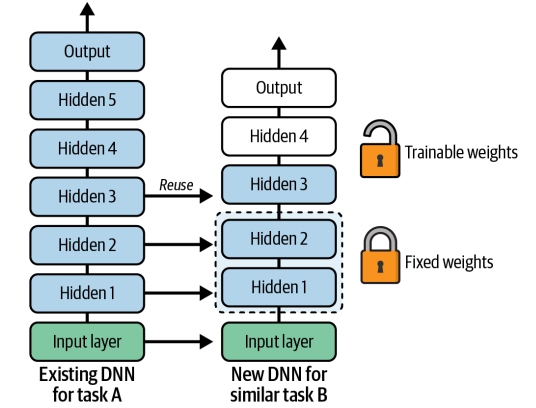

通常，原始模型的输出层应该被替换，因为它很可能对新任务完全没有用处，而且可能没有正确的输出数量。

类似地，原始模型的上层隐藏层不太可能像底层那样有用，因为对新任务最有用的高级特性可能与对原始任务最有用的高级特性有显著不同。您希望找到要重用的正确的层数。任务越相似，您希望重用的层就越多（从较低的层开始）。对于非常相似的任务，尝试保留所有隐藏层，并替换输出层。

首先尝试freezing所有重用的层（即，使它们的权重不可训练，这样梯度下降就不会修改它们，它们将保持固定），然后训练你的模型，看看它如何执行。然后尝试解冻一到两个顶级隐藏层，让反向传播调整它们，看看性能是否有所提高。训练数据越多，可以解冻的图层就越多。当您解冻可重用的图层时，降低学习率也很有用：这将避免破坏它们的微调权重。

如果您仍然不能获得良好的性能，并且您几乎没有训练数据，请尝试删除顶部隐藏层(s)，并再次冻结所有剩余的隐藏层。

您可以进行迭代，直到找到要重用的正确层数。如果您有大量的训练数据，您可以尝试替换顶部的隐藏层，而不是删除它们，甚至添加更多的隐藏层。

### 6.1 用Keras迁移学习（Transfer Learning with Keras）

让我们来看一个例子。假设Fashion MNIST数据集只包含8个类——例如，除了凉鞋和衬衫之外的所有类。有人在该集合上建立并训练了一个Keras模型，并获得了相当好的性能（>90%的准确率）。让我们把这个模型叫做 $A$ 。你现在想要处理另一项任务：你有t恤和套头衫的图片，你想训练一个二元分类器：t恤（和上衣）是正，凉鞋是负。你的数据集非常小；你只有200张贴有标记的图像。当您使用与模型 $A$ 相同的架构为此任务训练一个新模型（让我们称之为模型 $B$ ）时，您将得到91.85%的测试精度。当你早上喝咖啡时，你意识到你的任务和任务A很相似，所以也许迁移学习可以有所帮助？让我们看看！

In [17]:
# split Fashion MNIST into tasks A and B
# then train and save model A to "my_model_A".

import numpy as np

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 2s 1ms/step - loss: 1.1487 - accuracy: 0.6291 - val_loss: 0.6799 - val_accuracy: 0.7744
Epoch 2/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.5973 - accuracy: 0.7955 - val_loss: 0.5087 - val_accuracy: 0.8240
Epoch 3/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4867 - accuracy: 0.8364 - val_loss: 0.4383 - val_accuracy: 0.8473
Epoch 4/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.4280 - accuracy: 0.8570 - val_loss: 0.3930 - val_accuracy: 0.8629
Epoch 5/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3896 - accuracy: 0.8694 - val_loss: 0.3642 - val_accuracy: 0.8719
Epoch 6/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3629 - accuracy: 0.8780 - val_loss: 0.3436 - val_accuracy: 0.8819
Epoch 7/20
1376/1376 [==============================] - 2s 1ms/step - loss: 0.3435 - accuracy: 0.8839 - val_loss: 0.3279 - val_accuracy:

In [18]:
# train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 24ms/step - loss: 0.7201 - accuracy: 0.5550 - val_loss: 0.6986 - val_accuracy: 0.5134
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6618 - accuracy: 0.5750 - val_loss: 0.6564 - val_accuracy: 0.5678
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6257 - accuracy: 0.6400 - val_loss: 0.6267 - val_accuracy: 0.6360
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5950 - accuracy: 0.7100 - val_loss: 0.5989 - val_accuracy: 0.7181
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5683 - accuracy: 0.7800 - val_loss: 0.5718 - val_accuracy: 0.7992
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5414 - accuracy: 0.8300 - val_loss: 0.5477 - val_accuracy: 0.8467
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5170 - accuracy: 0.8750 - val_loss: 0.5258 - val_accuracy: 0.8764
Epoch 8/20
7/7 [=================

[0.36956414580345154, 0.9269999861717224]

In [19]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

请注意，model_A和model_B_on_A现在共享了一些层。在训练model_B_on_A时，它也会影响model_A。如果要避免这种情况，则需要先克隆它才能重用model_A层。为此，您可以使用 **clone_model()** 克隆模型A的体系结构，然后复制其权重：

In [20]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

tf.keras.models.clone_model() 只克隆了体系结构，而不是权重。如果不使用set_weights()手动复制它们，它们将在首次使用克隆模型时随机初始化。

现在可以为任务B训练model_B_on_A，但是由于新的输出层是随机初始化的，所以它会产生很大的错误（至少在前几个阶段），因此会有很大的错误梯度，可能会破坏重用的权重。为了避免这种情况，一种方法是在最初的几个阶段冻结被重用的层，给新的层一些时间来学习合理的权重。为此，请将每个层的可训练属性设置为False，并编译模型：

In [22]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model_B_on_A.compile(loss="binary_crossentropy", 
                     optimizer=optimizer,
                     metrics=["accuracy"])

**在冻结或解冻图层之后，必须始终编译模型。**

现在您可以训练模型几个epoch，然后解冻重用层（这需要再次编译模型），并继续训练微调任务 $B$ 的重用层。解冻重用层后，降低学习率通常是一个好主意，以避免损害重用的权重。

In [23]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model_B_on_A.compile(loss="binary_crossentropy", 
                     optimizer=optimizer,
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 23ms/step - loss: 0.6689 - accuracy: 0.6350 - val_loss: 0.6526 - val_accuracy: 0.6380
Epoch 2/4
7/7 [==============================] - 0s 9ms/step - loss: 0.6571 - accuracy: 0.6400 - val_loss: 0.6437 - val_accuracy: 0.6479
Epoch 3/4
7/7 [==============================] - 0s 8ms/step - loss: 0.6479 - accuracy: 0.6450 - val_loss: 0.6402 - val_accuracy: 0.6558
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.6340 - accuracy: 0.6700 - val_loss: 0.6333 - val_accuracy: 0.6568
Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 0.6015 - accuracy: 0.7000 - val_loss: 0.5660 - val_accuracy: 0.7389
Epoch 2/16
7/7 [==============================] - 0s 9ms/step - loss: 0.5425 - accuracy: 0.7850 - val_loss: 0.5153 - val_accuracy: 0.7883
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.4901 - accuracy: 0.8150 - val_loss: 0.4823 - val_accuracy: 0.8160
Epoch 4/16
7/7 [====================

那么，最终的判决是什么呢？这个模型的测试准确率是93.85%，比91.85%正好上升了2个百分点！这意味着迁移学习降低了近25%的错误率：

In [24]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.2717 - accuracy: 0.9205


[0.27173763513565063, 0.9204999804496765]

你相信吗？我欺骗了！我尝试了很多配置，直到我发现了一个有显著改进的配置。如果您尝试更改类或随机种子，您将会看到改进通常会下降，甚至会消失或逆转。我所做的是称为“折磨数据，直到它坦白”。当一篇论文看起来太积极，你应该怀疑：也许华丽的新技术实际上没有帮助（事实上，它甚至可能降低性能），但作者尝试许多变量和报告只有最好的结果（这可能是由于纯粹的运气），没有提到多少他们遇到的失败。大多数情况下，这根本就不是恶意的，但这也是科学上的许多结果永远无法复制的部分原因。

我为什么作弊？事实证明，迁移学习在小型密集网络中并不是很好，这可能是因为小型网络学习到的模式很少，而密集网络学习到非常特定的模式，这在其他任务中不太可能有用。**迁移学习最适合于深度卷积神经网络，它倾向于学习更一般的特征检测器（特别是在较低的层）**。我们将在第14章中重新讨论迁移学习，使用我们刚才讨论过的技术（我保证这次不会有作弊！）。

### 6.2 无监督预训练（Unsupervised Pretraining）

假设您想要处理一个复杂的任务，其中您没有太多带标记的训练数据，但不幸的是，您无法找到一个经过类似任务训练的模型。不要失去希望！首先，您应该尝试收集更多有标签的训练数据，但如果不能，您可能仍然可以执行无监督的预训练，如下图

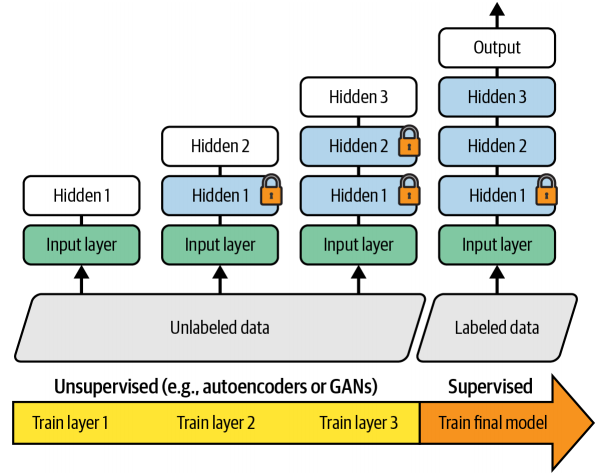

事实上，收集没有标记的训练例子通常很便宜，但贴上标签却很昂贵。如果您能收集到大量未标记的训练数据，您可以尝试使用它来训练无监督模型，例如自动编码器或生成对抗网络（GAN；参见第17章）。然后，您可以重用自动编码器的下层或GAN鉴别器的下层，在顶部添加您的任务的输出层，并使用监督学习（即，带有标记的训练示例）来微调最终的网络。

正是Geoffrey Hinton和他的团队在2006年使用的这种技术，导致了神经网络的复兴和深度学习的成功。直到2010年，无监督预训练——通常是使用**受限玻尔兹曼机（restricted Boltzmann machines，RBMs）**——是深网的常态，只有在梯度消失问题得到缓解后，纯粹使用监督学习来训练DNNs才变得更加常见。当你有一个复杂的任务要解决，没有类似的模型可以重用，很少有标记的训练数据，但有大量未标记的训练数据时，无监督的预训练（**今天通常使用自动编码器或GANs而不是RBMs**）仍然是一个很好的选择。

请注意，在深度学习的早期，是很难训练深度模型的，所以人们会使用一种称为 **贪心逐层预训练（greedy layer-wise pretraining）** 的技术（如上图所示）。他们将首先训练一个无监督模型，通常一个RBM，然后他们会冻结该层并添加另一层，然后再次训练模型（有效地训练新层），然后冻结新层和添加另一层，再次训练模型，等等。

**如今，事情要简单得多：人们通常一次性训练完整的无监督模型，并使用自动编码器或GANs而不是RBMs。**

### 6.3 对辅助任务的预训练（Pretraining on an Auxiliary Task）

如果你没有太多的有标记的训练数据，最后一个选择是对第一个神经网络在一个辅助任务上进行训练，你可以很容易地获得或生成有标记的训练数据，然后在你的实际任务中重用该网络的底层。第一个神经网络的下层将学习有可能被第二个神经网络重复使用的特征检测器。

例如，如果你想建立一个识别人脸的系统，你可能只有每个人的几张照片——显然不足以训练一个好的分类器。收集每个人的数百张照片是不现实的。然而，你可以在网上随机收集很多人的照片，然后训练第一个神经网络来检测两个不同的图片是否包含同一个人。这样的网络可以为人脸学习好的特征检测器，所以重用它的下层将允许你训练一个使用很少的训练数据的好的人脸分类器。

对于自然语言处理（NLP）应用程序，您可以下载包含数百万个文本文档的语料库，并从中自动生成标记数据。例如，您可以随机屏蔽一些单词，并训练一个模型来预测缺失的单词是什么(例如，它应该预测缺失的单词在句子“What ___ you saying？”可能是“are”或“were”)。如果你能训练一个模型在这个任务上达到良好的性能，那么它已经知道很多语言，你当然可以在实际任务中重用它，并根据你的标记数据对其进行微调（我们将在第15章讨论更多的预训练任务）。

自监督学习是指从数据本身自动生成标签，就像在文本屏蔽示例中一样，然后您使用监督学习技术在生成的“标记”数据集上训练一个模型。

## 7. 更快的优化器（Faster Optimizers）

训练一个非常大的深度神经网络可能会慢得令人痛苦。到目前为止，我们已经看到四种方法加快训练（并达到更好的解决方案）：应用良好的初始化策略，使用良好的激活函数，使用批规范化，重用部分预先训练好的网络（可能为一个辅助任务或使用无监督学习）。

另一个巨大的速度提升来自于使用比常规梯度下降优化器更快的优化器。在本节中，我们将介绍最流行的优化算法： momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, Adam及其变体。

### 7.1 Momentum

想象一下，一个保龄球在一个光滑的表面上滚下一个平缓的斜坡：它会缓慢地开始，但它会迅速增加动量，直到最终达到最终速度（如果有一些摩擦或空气阻力）。这是动量优化背后的核心思想，由鲍里斯·波利亚克在1964年提出。而坡度平缓时常规梯度下降步长小，坡度陡时步长大，但速度不会加快。因此，规则梯度下降通常比动量优化达到最小值要慢得多。

回想一下，梯度下降通过直接减去代价函数 $j(\pmb{\theta})$ 关于权重 $\Delta_{\theta}j(\pmb{\theta})$ 的梯度乘以学习率 $η$ 来更新权重 $\pmb{θ}$ 。该方程为 $\pmb{θ}←\pmb{θ}-η∇_{\pmb{θ}}J(\pmb{θ})$ 。它并不关心早期的梯度是什么。如果局部梯度很小，它就会非常慢。

动量优化非常关心以前的梯度是什么：在每次迭代中，它从动量向量 $\pmb{m}$ 减去局部梯度（乘学习率 $\eta$ ），并通过添加这个动量向量来更新权值。换句话说，梯度被用作加速度，而不是速度。为了模拟某种摩擦机制，防止动量变大，该算法引入了一种新的超参数 $β$ ，称为动量，它必须设置在0（高摩擦）和1（无摩擦）之间。一个典型的动量值是0.9。

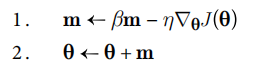

您可以验证，如果梯度保持不变，则终端速度（即权重更新的最大大小）等于该梯度乘以学习速率 $η$ 乘以 $1/(1-β)$ (忽略符号）。

例如，如果 $β=0.9$ ，那么终端速度等于梯度的10倍乘以学习速率，所以动量优化最终的速度比梯度下降快10倍！这使得动量优化能够比梯度下降的速度快得多地逃离高原。我们在第4章中看到，当输入有非常不同的尺度时，成本函数将看起来就像一个细长的碗。梯度下降沿着陡坡下降得很快，但随后沿着山谷下降需要很长一段时间。相比之下，动量优化将越来越快地沿着山谷滚动，直到它到达底部（最优值）。在不使用批处理归一化的深度神经网络中，上层通常会有非常不同尺度的输入，所以使用动量优化有很大帮助。它还可以帮助滚动通过本地最优值。

由于动量，优化器可能会超调一点，然后返回，再次超调，并在稳定在最小值之前像这样振荡多次。这就是系统中应该设置有一点摩擦的原因之一：它可以消除这些振荡，从而加速收敛速度。

In [25]:
# Implementing momentum optimization in Keras

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,
                                    momentum=0.9)

动量优化的一个缺点是，它增加了另一个超参数表来调谐。然而，0.9的动量值在实践中效果很好，而且几乎总是比常规梯度下降更快。

### 7.2 Nesterov加速梯度（Nesterov Accelerated Gradient）

由内斯特罗夫在1983年提出的动量优化的一个小变体，几乎总是比常规动量优化更快。**内斯特罗夫加速梯度（Nesterov Accelerated Gradient，NAG）方法**，也称为内斯特罗夫动量优化，在动量方向稍提前的 $\pmb{θ} + β\pmb{m}$ 计算代价函数的梯度不是在局部位置 $\pmb{θ}$ 。

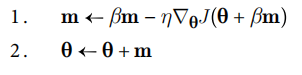

这个小调整有效，因为通常动量向量将指向正确的方向（即最佳），因此使用在该方向测量的梯度会更精确。

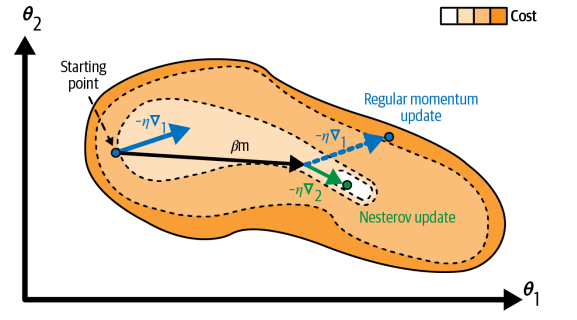

如图所示（其中 $∇_1$ 表示在起点 $\pmb{θ}$ 测量的成本函数的梯度，$∇_2$ 表示位于 $\pmb{θ}+β\pmb{m}$ 点的梯度）。

正如你所看到的，内斯特罗夫的更新最终更接近最佳状态。一段时间后，这些小的改进加起来，NAG最终比常规的动量优化明显更快。此外，请注意，当动量推动穿过山谷的权重时，$∇_1$ 继续继续穿过山谷，而 $∇_2$ 则向山谷的底部推进。这有助于减少振荡，从而使NAG收敛得更快。

In [26]:
# To use NAG
# set nesterov=True when creating the SGD optimizer

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, 
                                    momentum=0.9,
                                    nesterov=True)

### 7.3 AdaGrad

再考虑长碗问题：梯度下降从快速沿着最陡的斜坡开始，并没有直接指向全局最优，而是非常缓慢地下降到山谷的底部。如果算法能更早地纠正方向，更指向全局最优，那就太好了。**AdaGrad算法通过沿着最陡的维度缩小梯度向量来实现这种修正。**

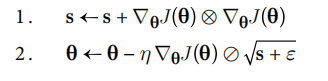

第一步将梯度的平方累积到向量 $\pmb{s}$ 中（ $⊗$ 符号表示元素方向的乘法）。这种向量化形式等价于计算向量 $\pmb{s}$ 的每个元素 $s_i$ 为 $s_i\leftarrow s_i+(\frac{\partial j(\pmb{\theta})}{\partial \theta_i})^2$ ；换句话说，每个 $s_i$ 累积代价函数对参数 $\theta_i$ 的偏导数的平方。如果代价函数沿第 $i$ 维很陡峭，那么 $s_i$ 在每次迭代中就会越来越大。

第二步几乎与梯度下降相同，但有一个很大的区别：梯度向量被 $\sqrt{\pmb{s}+\epsilon}$ 的因子缩小（ $⊘$ 符号表示元素级划分，$ε$ 是一个平滑项，以避免除0，通常设置为 $10^{-10}$ ）。这种向量化形式相当于同时计算所有参数 $\theta_i$ 的 $\theta_i\leftarrow \theta_i-\eta\frac{\partial j(\pmb{\theta})}{\partial\theta_i}/ \sqrt{s_i+\epsilon}$ 。

简而言之，该算法衰减了学习率，但它在陡峭的边界上比在坡度较平缓的维度上更快。这叫做**自适应学习率**，它帮助将结果更新更直接地指向全局最优。另一个好处是，它需要的调整学习速率超参数 $η$ 要少得多。

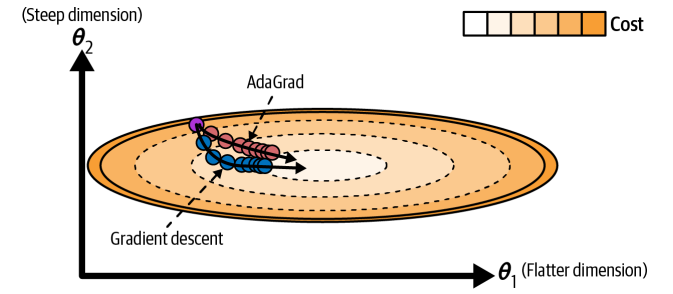

AdaGrad经常在简单的二次问题上表现良好，但当训练神经网络时，它往往停止得过早：学习速率缩小得如此之大，以至于算法在达到全局最优之前完全停止。因此，即使Keras有一个Adagrad优化器，你也不应该使用它来训练深度神经网络（不过，它对于更简单的任务可能是有效的）。尽管如此，理解AdaGrad仍然有助于理解其他自适应学习率优化器。

### 7.4 RMSProp

正如我们所看到的，AdaGrad面临着稍微减速太快的风险，而且永远不会接近全局最优。RMSProp算法通过只积累最近一次迭代中的梯度来解决这个问题，而不是自训练开始以来的所有梯度。它通过在第一步中使用指数衰减来实现这一点。

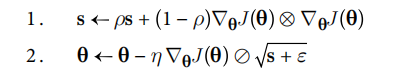

衰减率 $ρ$ 通常设置为0.9。这是一个新的超参数，但是这个默认值通常工作得很好，所以您可能根本不需要调优它。

In [27]:
# Keras has an RMSprop optimizer:

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                        rho=0.9)

除了非常简单的问题外，这个优化器几乎总是比AdaGrad的性能好得多。事实上，在Adam优化算法出现之前，该优化算法一直是许多研究人员首选的优化算法。

### 7.5 Adam

Adam，是 **自适应矩估计（adaptive moment estimation，Adam）** 的缩写，它结合了momentum优化和RMSProp的思想：就像动量优化一样，它跟踪过去梯度的指数衰减平均值；就像RMSProp一样，它跟踪过去平方梯度的指数衰减平均值。这些是对梯度的平均值和（无中心）方差的估计。均值通常被称为第一矩，而方差通常被称为第二矩，因此这是算法的名称。

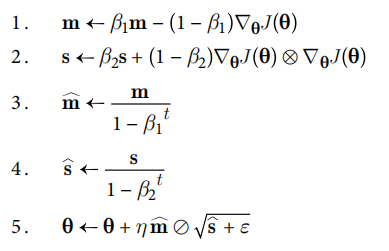

其中 $t$ 表示迭代次数。

如果你只看步骤1、2和5，你会注意到Adam与动量优化和RMSProp都非常相似：$β_1$ 对应于动量优化中的 $β$ ，$β_2$ 对应于RMSProp中的 $ρ$ 。唯一的区别是，步骤1计算的是指数衰减平均值，而不是指数衰减和，但这些实际上是等价的，除了一个常数因子（衰减平均值只有 $1-β_1$ 乘以衰减和）。

步骤3和4是一些技巧细节：由于 $\pmb{m}$ 和 $\pmb{s}$ 初始化为0，它们在训练开始时将偏向于0，所以这两个步骤将有助于在训练开始时提高 $\pmb{m}$ 和 $\pmb{s}$ 。

动量衰减超参数 $β_1$ 通常初始化为0.9，而缩放衰减超参数 $β_2$ 通常初始化为0.999。如前所述，平滑项 $ε$ 通常被初始化为一个很小的数字，如 $10^{-7}$ 。这些都是Adam类的默认值。

In [28]:
#  create an Adam optimizer using Keras：

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, 
                                     beta_1=0.9,
                                     beta_2=0.999)

由于Adam是一种自适应学习速率算法，就像AdaGrad和RMSProp一样，它需要更少的学习速率超参数 $η$ 的调整。您可以经常使用默认值 $η=0.001$，这使Adam比梯度下降更容易使用。

最后，Adam 的三种变体值得一提： AdaMax, Nadam, 和 AdamW。

### 7.6 AdaMax

Adam 的论文还介绍了 **AdaMax** 。请注意，在方程的第2步中，Adam将s中的梯度的平方相加（对于最近的梯度有更大的权重）。在步骤5中，如果我们忽略 $ε$ 和步骤3和步骤4（无论如何这些都是技术细节），Adam将根据 $s$ 的平方根来缩小参数更新。简而言之，Adam通过时间衰减梯度的 $ℓ_2$ 范数来缩小参数更新（ $ℓ_2$ 范数是平方和的平方根）。

AdaMax用 $ℓ_∞$ 规范取代了 $ℓ_2$ 规范（一种max的表达方式）。具体地说，它用 $s\leftarrow max(β_2\pmb{s},abs(\nabla_{\pmb{\theta}}j(\pmb{\theta})))$ 取代了公式中的步骤2，它移除了步骤4，并且在第5步中，它将梯度更新缩小了 $\pmb{s}$ 倍，这是时间衰减梯度的绝对值的最大值。

在实践中，这可以使AdaMax比Adam更稳定，但它实际上取决于数据集，而且一般来说Adam表现得更好。所以，如果你在Adam的某些任务上遇到了问题，这只是你可以尝试的另一个优化器。

### 7.7 Nadam

Nadam优化是Adam优化加上Nesterov的技巧，所以它的收敛速度通常会比Adam稍微快一些。在他介绍这种技术的报告中，研究人员Timothy Dozat比较了各种任务上的许多不同的优化器，发现Nadam一般优于Adam，但有时也优于RMSProp。

### 7.8 AdamW

AdamW是Adam的一种变体，它集成了一种称为**权重衰减**的正则化技术。在每次训练迭代中，通过将它们乘以一个衰减因子，如0.99，权重衰减来减小模型的权重的大小。这可能会提醒你 $ℓ_2$ 正则化，它也旨在保持权值较小，而且确实可以从数学上证明，当使用SGD时，$ℓ_2$ 正则化等同于权值衰减。然而，当使用Adam或其变体时，$ℓ_2$ 正则化和权重衰减是不相等的：在实践中，将Adam与 $ℓ_2$ 正则化结合起来，所得到的模型往往不能泛化，以及SGD产生的模型。AdamW 通过适当地将Adam与权重衰减结合起来，解决了这个问题。

自适应优化方法（包括RMSProp、Adam、AdaMax、Nadam和AdamW优化）通常都很好，可以快速转换为一个好的解决方案。然而，Ashia C. Wilson等人在2017年发表的一篇论文表明，它们可以导致在某些数据集上推广性较差的解决方案。因此，当你对模型的性能感到失望时，尝试使用**NAG**代替：**你的数据集可能只是对自适应梯度过敏**。也可以看看最新的研究，因为它进展得很快。

要在Keras中使用Nadam、AdaMax或AdamW，需要替换 **tf.keras.optimiz.Adam** 与 **tf.keras.optimizers.Nadam**，**tf.keras.optimizers.Adamax**，或 **tf.keras.optimizers.experimental.AdamW**。对于AdamW，您可能想要调整 weight_decay 超参数。

迄今为止所讨论的所有优化技术都只依赖于一阶偏导数（雅可比矩阵）。优化文献中也包含了基于二阶偏导数的算法（黑森矩阵，这是雅可比矩阵的偏导数）。不幸的是，这些算法很难应用于深度神经网络，因为每个输出有 $n^2$ 个黑森函数（其中 $n$ 是参数的数量），而不是每个输出只有 $n$ 个雅可比函数。由于 DNN 有数万个或更多的参数，二阶优化算法通常甚至不适合内存，即使它们适合，计算黑森也太慢了。

**比较到目前为止我们讨论过的所有优化器（\*是坏的，\*\*是平均的，而\*\*\*是好的）。**

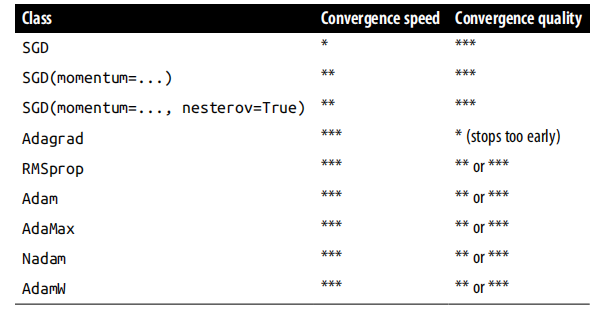

## 8. 学习率调度（Learning Rate Scheduling）

找到一个好的学习速度是非常重要的。如果你把它设置得太高，训练可能会出现分歧。如果你设置得太低，训练最终会收敛到最佳状态，但这将需要很长时间。如果你把它设置得稍微太高一点，它在一开始会很快取得进步，但它最终会围绕着最佳的方向跳舞，永远不会真正安定下来。如果您的计算预算有限，那么您可能不得不在训练正确收敛之前中断训练，从而产生一个次优的解决方案。

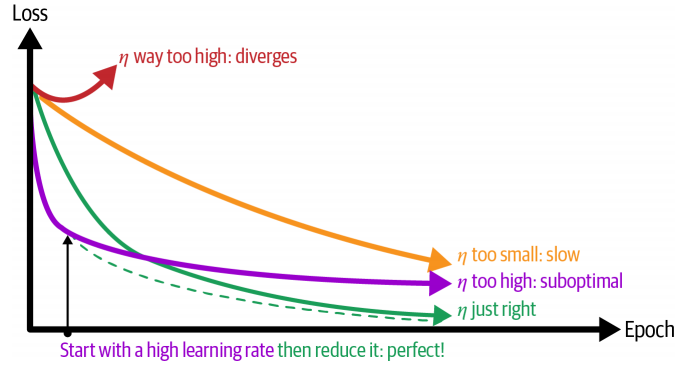

第十章中讨论，你可以通过训练模型几百迭代找到一个好的学习率，指数增加学习率从一个非常小的值到一个非常大的值，然后看着学习曲线和选择学习率略低于学习曲线开始反弹。然后，您可以重新初始化您的模型，并使用该学习速率来训练它。

但是你可以比一个恒定的学习率做得更好：如果你从一个大的学习率开始，然后一旦训练停止快速进步就减少它，你可以比使用最佳的恒定学习率更快地得到一个好的解决方案。有许多不同的策略来降低学习率。从低学习率开始，增加它，然后再放弃它也是有益的。这些策略被称为 **learning schedules**。

**以下是最常用的学习调度：**

1. **幂调度（Power scheduling）**：将学习速率设置为迭代次数 $t$ 的函数：$η(t)=η_0 /（1 + t/s）^c$ 的函数。初始学习速率 $η_0$ 、幂 $c$（通常设置为1）和步数 $s$ 都是超参数。每一步的学习速度都会下降。经过 $s$ 步后，学习率降至 $η_0/2$ 。再经过 $s$ 步后，下降到 $η_0/3$ ，然后下降到 $η_0/4$ ，然后是 $η_0/5$ ，以此类推。正如您所看到的，这个时间表首先下降得很快，然后下降越来越慢。当然，幂调度需要调优 $η_0$ 和 $s$（可能还有 $c$ ）。
2. **指数调度（Exponential scheduling）**：将学习速率设置为 $η(t)=η_0 0.1^{t/s}$ 。学习速率每秒步就会逐渐下降10倍。当幂调度会越来越慢地降低学习速率时，指数调度则会使其每秒步不断降低10倍。
3. **分段常数调度（Piecewise constant scheduling）**：对多个epoch使用恒定的学习率（例如，5个epoch使用 $η_0=0.1$ ），然后对另一个epoch使用较小的学习率（例如，50个epoch使用 $η_1=0.001$ ），以此类推。虽然这个解决方案可以很好地工作，但它需要摆弄清楚正确的学习速率序列，以及使用多长时间。
4. **性能调度（Performance scheduling）**：每 $N$ 步测量验证误差（就像早期停止一样），当误差停止下降时，将学习速率降低 $λ$ 倍。
5. **单周期调度（1cycle scheduling）**：Leslie Smith在2018年的一篇论文中介绍了1cycle。与其他方法相反，它从增加初始学习率 $η_0$ 开始，在训练的中途呈线性增长到 $η_1$ 。然后在训练的后半段，它再次将学习率线性降低到 $η_0$ ，通过降低几个数量级（仍然是线性的）来结束最后几个阶段。最大学习率 $η_1$ 的选择方法与我们寻找最优学习率的方法相同，而初始学习率 $η_0$ 通常要低10倍。当使用动量时，我们首先从高动量开始（例如，0.95），然后在训练的前半部分将它下降到较低的动量（例如，下降到0.85，线性），然后将它恢复到最大值（例如，0.95）在训练的后半部分，以最大值完成最后几个时期。史密斯做了许多实验，表明这种方法通常能够大大加快训练速度，并达到更好的表现。

在Keras中实现 power scheduling 是最简单的选择：在创建优化器时，只需设置 **decay** 超参数：

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, 
                                    decay=1e-4)

decay 是 s（将学习速率除以一个单位所需的步数）的倒数，Keras假设c等于1。

指数调度和分段调度也很简单。您首先需要定义一个函数，它获取当前的epoch并返回学习率。例如，让我们实现指数调度：

In [30]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

如果您不想硬编码 $η_0$ 和 $s$ ，您可以创建一个返回已配置函数的函数：

In [32]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

接下来，创建一个 LearningRateScheduler 回调，给它调度函数，并将此回调传递给 fit() 方法：

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, [...],
                    callbacks=[lr_scheduler])

LearningRateScheduler 将在每个epoch的开始时更新优化器的learning_rate属性。每个epoch更新一次学习速率通常就足够了，但是如果你想更频繁地更新它，例如在每一步，可以编写自己的回调。如果每个epoch都有许多步，那么在每一步更新学习速率可能会有帮助。或者，也可以使用tf.keras.optimizers.schedules 的方法。

训练结束后，**history.history["lr"]** 允许访问培训期间使用的学习速率列表。

调度函数可以选择将当前的学习速率作为第二个参数。

例如，下面的调度函数将之前的学习速率乘以 $0.1^{1/20}$，这导致了相同的指数衰减（除了衰减现在从epoch0开始而不是epoch1开始）：

In [35]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

这个实现依赖于优化器的初始学习速率（与之前的实现相反），因此请确保适当地设置它。

当保存一个模型时，优化器和它的学习速率将随之保存。这意味着有了这个新的调度功能，可以只加载一个训练的模型并在它停止的地方继续训练。但是，如果您的调度函数使用epoch参数，那么事情就不那么简单了：epoch不会被保存，并且每次调用fit()方法时，它都会被重置为0。如果你继续训练一个模型的中断，这可能会导致一个非常大的学习率，这可能会损害你的模型的权重。一种解决方案是手动设置 fit() 方法的 initial_epoch 参数，这样epoch就从正确的值开始。

对于分段常数调度，您可以使用下面的调度函数，然后使用这个函数创建一个 LearningRateScheduler 回调，并将其传递给 fit() 方法，就像指数调度一样：

In [36]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

对于性能调度，使用ReduceLROnPlateau回调。例如，如果您将以下回调传递到 fit() 方法，当最佳验证损失在连续5个时期没有改善时，它将把学习率乘以0.5（还有其他选项；请查看文档了解更多细节）：

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, 
                                                    patience=5)
history = model.fit(X_train, y_train, [...], 
                    callbacks=[lr_scheduler])

最后，Keras提供了一种实现学习率调度的替代方法：可以使用tf.keras.optimizers.schedules中可用的一个类来定义计划学习率，然后把它传递给任何优化器。这种方法在每一步更新学习速率，而不是更新每个epoch。

例如，下面是如何实现与我们前面定义的exponential_decay_fn（）函数相同的指数时间表：

In [37]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)

scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, 
    decay_steps=n_steps, 
    decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

至于1cycle，Keras不支持它，但是通过创建一个自定义回调来修改每次迭代的学习速率，它可以在不到30行的代码中实现它。要从回调的 on_batch_begian() 方法中更新优化器的学习率，需要调用 tf.keras.backend.set_value（self.model.optimizer.learning_rate，new_learning_rate）。有关示例，请参见notebook中的“1cycle计划”部分。

## 9. 通过正则化避免过拟合（Avoiding Overfitting Through Regularization）

我们已经在第10章中实现了最好的正则化技术之一：早期停止。此外，尽管批处理归一化被设计用来解决不稳定的梯度问题，但它也就像一个很好的正则化器。在本节中，我们将研究其他流行的神经网络的正则化技术：$ℓ_1$ 和 $ℓ_2$ 正则化，dropout，和max-norm正则化。

### 9.1 $ℓ_1$ 和 $ℓ_2$ 正则化

可以使用 $ℓ_2$ 正则化来约束神经网络的连接权值，如果你想要一个稀疏模型（许多权值等于0），还可以使用 $ℓ_1$ 正则化。下面展示如何将 $ℓ_2$ 正则化应用到Keras层的连接权值，使用的正则化因子为0.01：

In [38]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

**l2()** 函数返回一个正则化器，在训练期间的每一步都会调用它来计算正则化损失。然后把它加到最后的损失中。正如所期望的，如果您想要 $ℓ_1$ 正则化，您可以使用 tf.keras.regularizers.l1()；如果您同时想要 $ℓ_1$ 和 $ℓ_2$ 正则化，请使用tf.keras.regularizers.l1_l2()（指定两个正则化因子）。

由于通常希望将相同的正则化器应用于网络中的所有层，以及在所有隐藏层中使用相同的激活函数和相同的初始化策略，因此您可能会发现自己在重复相同的参数。这使得代码丑陋且容易出错。为了避免这种情况，您可以尝试重构代码以使用循环。另一个选择是使用Python的 **functools.partial()** 函数，它允许为任何可调用的文件创建一个薄包装器，使用一些默认的参值：

In [39]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

正如我们之前看到的，当使用SGD、动量优化和Nesterov动量优化时，$ℓ_2$ 正则化是很好的，但对于Adam及其变体则不是。如果你想使用具有权重衰减的Adam，那么就不要使用 $ℓ_2$ 正则化：使用AdamW代替。

### 9.2 Dropout

Dropout是深度神经网络工作中最流行的正则化技术之一。许多最先进的神经网络使用Dropout，因为它给了一个1%-2%的准确率提高。这听起来可能不多，但当一个模型已经有95%的准确率时，获得2%的准确率提高意味着错误率下降近40%（误差从5%下降到大约3%）。

**Dropout算法**：在每一个训练步骤，每个神经元（包括输入神经元，但总是排除输出神经元）以概率 $p$ 暂时“退出”，这意味着它将完全忽略在这个训练步骤，但它可能是活跃在下一步。超参数 $p$ 被称为dropout rate，它通常设置在10%到50%之间：在递归神经网络中接近20%-30%（见第15章），在对流神经网络中接近40%-50%（见第14章）。训练结束后，神经元就不再dropout了。仅此而已（除了我们将稍后讨论的技术细节）。

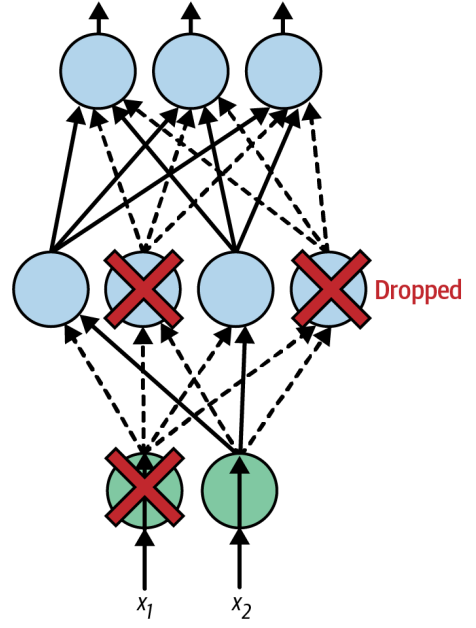

一开始令人惊讶的是，这种破坏性的技术完全有效。如果一家员工被告知每天早上抛硬币来决定是否去上班，该公司的表现会更好吗？嗯，谁知道呢；也许它会！该公司将被迫调整其组织结构；它不能依靠任何一个人来使用咖啡机或执行任何其他关键任务，所以这些专业知识必须分散到几个人身上。员工们必须学会与许多同事合作，而不仅仅是他们中的少数人。该公司将变得更有弹性。如果一个人辞职了，也不会有太大的影响。目前还不清楚这个想法是否真的适用于公司，但它确实适用于神经网络。经过dropout训练的神经元不能与邻近的神经元共同适应；它们必须自己尽可能地有用。它们也不能过度依赖于几个输入神经元；它们必须注意每一个输入神经元。它们最终对输入中的微小变化不那么敏感。最后，您将得到一个更健壮的网络。

另一种理解dropout能力的方法是意识到在每个训练步骤中都会产生一个独特的神经网络。由于每个神经元既可以存在，也可以不存在，所以总共有 $2N$ 个可能的网络（其中 $N$ 是可dropout神经元的总数）。这是一个如此巨大的数字，以至于几乎不可能对同一个神经网络进行采样两次。一旦你运行了10000个训练步骤，你基本上就训练了10000个不同的神经网络，每个网络只有一个训练实例。这些神经网络显然不是独立的，因为它们有许多相同的权重，但它们仍然都是不同的。由此得到的神经网络可以看作是所有这些较小的神经网络的平均集合。

有一个小但重要的技术细节。假设 $p = 75%$ ：在训练过程中，平均只有25%的神经元是活跃的。这意味着在训练后，一个神经元连接的输入神经元是训练时的四倍。为了弥补这一事实，我们需要在训练期间将每个神经元的输入连接权值乘以4。如果我们不这样做，神经网络将不会表现得很好，因为它会在训练期间和训练后看到不同的数据。更一般地，我们需要在训练过程中将连接权值除以keep概率（1-p）。

要使用Keras实现dropout，可以使用 **tf.keras.layers.Dropout** 层。在训练过程中，它随机删除一些输入（设置为0），并将剩余的输入除以keep概率。训练结束后，它什么也不做；它只是将输入传递给下一层。

下面的代码在每一个密集层之前应用dropout正则化，使用的dropout rate为0.2：

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
    kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
    kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

由于dropout只在训练期间活跃，比较训练损失和验证损失可能会产生误导。特别是，一个模型可能过拟合训练集，但有类似的训练和验证损失。因此，确保评估没有dropout的训练损失（例如，在训练后）。

如果您观察到模型存在过拟合，则可以增加dropout rate。相反，如果模型不适合训练集，您应该尝试降低退出率。它还可以帮助提高大层的辍学率，并降低小层的辍学率。此外，许多最先进的架构只在最后一个隐藏层之后使用dropout，所以如果完全退出太强，您可能想要尝试这个。

dropout 确实会显著降低收敛速度，但如果正确调优，它通常会产生更好的模型。所以，花费额外的时间和精力通常是非常值得的，特别是对于大型模型。

### 9.3 蒙特卡洛Dropout（Monte Carlo (MC) Dropout）

2016年Yarin Gal和Zoubin Ghahramani的一篇论文增加了更多使用dropout的好理由：

1. 首先，本文建立了dropout网络（即包含dropout层的神经网络）和近似贝叶斯推理之间的深刻联系，给dropout一个坚实的数学证明。
2. 其次，作者引入了一种名为**MC droput**的强大技术，它可以提高任何训练过的dropout模型的性能，而无需重新训练甚至修改它。它还提供了一个更好的衡量模型不确定性的度量，并且它可以在几行代码中实现。

如果这一切听起来像是一些“一个奇怪的技巧”点击诱饵，那么看看下面的代码。这是MC dropout的完整实现，促进了我们之前训练的辍学模型，而没有再训练它：

In [42]:
import numpy as np

y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])

y_proba = y_probas.mean(axis=0)

请注意，**model(X)** 类似于 **model.predict(X)** ，只是它返回一个张量而不是一个NumPy数组，并且它支持训练参数。在这个代码示例中，设置 training=True 可以确保Dropout层保持活动状态，因此所有的准备工作都会有所不同。我们只在测试集上做了100个预测，然后计算出它们的平均值。更具体地说，对模型的每次调用都返回一个矩阵，每个实例有一行，每个类有一列。因为有1万个实例在测试集和10个类中，矩阵形状\[10000,10\]。我们堆叠了100个这样的矩阵，所以y_probas是一个形为\[100,10000,10\]的三维数组。一旦我们在第一个维度（轴=0）上平均，我们得到y_proba，一个形为\[10000,10\]的数组，就像我们用单一预测得到的一样。就这些了！对开启dropout的多个预测进行平均，可以给我们一个蒙特卡罗估计，它通常比关闭dropout的单一预测的结果更可靠。

例如，让我们看看模型对Fashoon MNIST测试集中第一个实例的预测，关闭了退出：

In [43]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 68ms/step


array([[0.072, 0.051, 0.095, 0.097, 0.161, 0.154, 0.064, 0.108, 0.093,
        0.107]], dtype=float32)

该模型相当自信（84.4%），此图像属于9类（踝靴）。并与MC退出预测进行比较：

In [44]:
y_proba[0].round(3)

array([0.057, 0.051, 0.097, 0.087, 0.182, 0.154, 0.063, 0.117, 0.092,
       0.1  ], dtype=float32)

该模型似乎仍然更喜欢9类，但它的信心下降到了72.3%，5类（凉鞋）和7类（运动鞋）的估计概率增加了，这对鞋也是有道理的。

MC dropout倾向于提高模型的概率估计的可靠性。这意味着它不太可能是自信的，而错误的，这可能是危险的：想象一下一辆自动驾驶汽车自信地无视停车标志。确切地知道哪些其他类最有可能也很有用。此外，您还可以查看概率估计的标准偏差：

In [45]:
y_std = y_probas.std(axis=0)

y_std[0].round(3)

array([0.018, 0.019, 0.024, 0.021, 0.051, 0.039, 0.021, 0.038, 0.025,
       0.024], dtype=float32)

显然有相当多的方差的概率估计类9：标准差是0.183，应该与估计概率0.723对比：如果你正在构建一个风险敏感系统（例如，医疗或金融系统），你可能会非常谨慎地对待这样一个不确定的预测。你绝对不会把它当作一个84.4%的自信预测。该模型的准确率也（非常）从87.0%提高到87.2%：

In [48]:
y_pred = y_proba.argmax(axis=1)

accuracy = (y_pred == y_test).sum() / len(y_test)

accuracy

0.1014

您使用的蒙特卡罗样本数（在本例中为100个）是一个您可以调整的超参数。它越高，预测及其不确定性估计就越准确。但是，如果你把它翻倍，推理时间也会翻倍。此外，超过一定数量的样本，你会注意到没有什么改进。您的工作是在应用程序中找到延迟和准确性之间的正确权衡。

如果您的模型包含在训练期间以特殊方式行为的其他层（如批标准化层），那么不应该像刚才做的那样强制执行训练模式。相反，您应该用以下 **MCDropout** 类替换Dropout层：

In [49]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)

在这里，我们只需对 Dropout 层进行子类化，并覆盖 call() 方法，以强制执行其训练参数为True。类似地，您可以通过子类化AlphaDropout来定义MCAlpha Dropout类。如果你是从零开始创建一个模型，这只是一个使用MCDropout而不是Dropout的问题。但是，如果你有一个模型已经使用Dropout训练过，你需要创建一个与现有模型相同的新模型，除了使用MCDropout而不是Dropout，然后将现有模型的权重复制到你的新模型中。

简而言之，MCDropout是一种很好的技术，它可以提高Dropout模型，并提供更好的不确定性估计。当然，因为它只是在训练中经常退出，它也像一个规则化器。

### 9.4 最大范数正则化（Max-Norm Regularization）

另一种流行的神经网络的正则化技术称为**最大范数正则化**：对于每个神经元，它约束传入连接的权值 $\pmb{w}$ ，使 $||\pmb{w}||_2≤r$ ，其中 $r$ 是最大范数超参数，$||·||_2$ 是 $ℓ_2$ 范数。

最大范数正则化并没有向总体损失函数增加一个正则化损失项。相反，它通常是通过在每个训练步骤后计算 $||\pmb{w}||_2$ ，并在需要时重新调整 $\pmb{w}$（ $\pmb{w}←\frac{\pmb{w} r} {||\pmb{w}||_2}$ ）来实现的。

减少 $r$ 增加了正则化的数量，并有助于减少过拟合。最大范数正则化还可以帮助缓解不稳定的梯度问题（如果您不使用批处理归一化）。

要在Keras中实现最大范数正则化，将每个隐藏层的kernel_constraint参数设置为一个具有适当的最大值的max_norm()约束，如下所示：

In [50]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

每次训练迭代后，模型的fit()方法将调用max_norm()返回的对象，将其传递给层的权值，然后得到重新缩放的权值，然后替换层的权值。正如您将在第12章中看到的，如果有必要，您可以定义自己的自定义约束函数，并将其用作内核约束。您还可以通过设置bias_constraint参数来约束偏差项。

max_norm()函数有一个默认值为0的axis参数。密集层通常具有 \[number of inputs, number of neurons\] 形状的权值，因此使用axis=0表示最大范数约束将独立地应用于每个神经元的权值向量。

如果要对卷积层使用最大范数（参见第14章），请确保适当地设置max_norm（）约束的axis参数（通常是axis=\[0,1,2\]）。

## 10. 总结和实践指南

在本章中，我们涵盖了广泛的技术，您可能会知道您应该使用哪些技术。这取决于任务，目前还没有明确的共识，但表中的配置在大多数情况下都可以很好地工作，而不需要太多超参数调优。

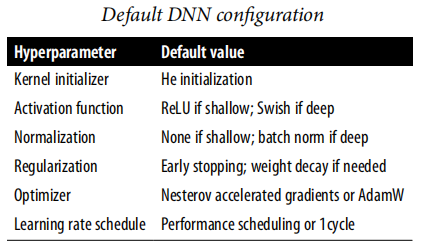

也就是说，请不要把这些默认值视为硬规则！

如果网络是一个简单的密集层堆栈，那么它可以自规范化，并且您应该使用下表中的配置来代替。

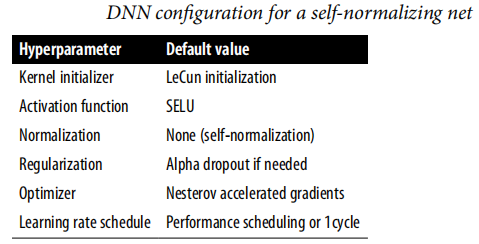

别忘了规范化输入！你还应该尝试重用部分预先训练的神经网络如果你能找到一个解决类似的问题，或使用无监督预训练如果你有很多未标记的数据，或使用预训练辅助任务如果你有很多标记数据类似的任务。

虽然之前的指导方针应该涵盖大多数情况，但这里有一些例外：

1. 如果你需要一个稀疏模型，你可以使用 $ℓ_1$ 正则化（并选择在训练后零化小权值）。如果需要一个更稀疏的模型，可以使用TensorFlow模型优化工具包。这将破坏自规范化，因此在这种情况下，您应该使用默认配置。
2. 如果您需要一个低延迟模型（一个执行闪电快速预测的模型），您可能需要使用更少的层，使用快速激活函数，如ReLU或leaky ReLU，并在训练后将批处理标准化层折叠到前面的层中。拥有一个稀疏模型也会有所帮助。最后，您可能希望将浮点数精度从32位降低到16位甚至8位（参见第741页上的“将模型部署到移动或嵌入式设备”）。再次，查看TF-MOT。
3. 如果您正在构建一个风险敏感的应用程序，或者推理延迟在应用程序中不是很重要，那么您可以使用MCdroput来提高性能，并获得更可靠的概率估计以及不确定性估计。